In [1]:
import sys
import os
SCRIPT_DIR = os.path.dirname(os.path.abspath("."))
sys.path.append(SCRIPT_DIR)
import helper
from utils import data_utils
import matplotlib.pyplot as plt
from utils import training_utils
from utils import data_utils
import torch
from model import models
import json
import os
from model import lightning_models
import math
from torchvision import datasets
import analysis_utils
import numpy as np
import torchvision
from torchvision.transforms import v2

/home/guanming/miniconda3/envs/mydl/lib/python3.8/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.6 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
n_views = 128
batch_size = 8
model_dir = "../best_cifar10"

In [3]:
config = helper.Config(model_dir,default_config_file="../default_configs/default_config_cifar10.ini")
if "CIFAR" in config.DATA["dataset"] or "MNIST" in config.DATA["dataset"]:
    prune_backbone = True
else:
    prune_backbone = False
ssl_model = lightning_models.CLAP(backbone_name = config.SSL["backbone"],
                                  prune = prune_backbone,
                                  use_projection_head=config.SSL["use_projection_head"],
                                  proj_dim = config.SSL["proj_dim"],
                                  proj_out_dim = config.SSL["proj_out_dim"],
                                  loss_name= config.SSL["loss_function"],
                                  optim_name = config.SSL["optimizer"],
                                  lr = 1.0,
                                  scheduler_name = config.SSL["lr_scheduler"],
                                  momentum = config.SSL["momentum"],
                                  weight_decay = config.SSL["weight_decay"],
                                  eta = config.SSL["lars_eta"],
                                  warmup_epochs = config.SSL["warmup_epochs"],
                                  n_epochs = config.SSL["n_epochs"],
                                  n_views = config.DATA["n_views"],
                                  batch_size = config.SSL["batch_size"],
                                  lw0 = config.SSL["lw0"],
                                  lw1 = config.SSL["lw1"],
                                  lw2 = config.SSL["lw2"],
                                  rs = config.SSL["rs"],
                                  pot_pow = config.SSL["pot_pow"])

Loading default settings...
[SemiSL]does not exist in the config file
[TL]does not exist in the config file
[KNN]does not exist in the config file
[SemiSL]does not exist in the config file
[TL]does not exist in the config file
[KNN]does not exist in the config file
[INFO]
num_nodes = 1
gpus_per_node = 1
cpus_per_gpu = 8
prefetch_factor = 2
precision = 16-mixed
fix_random_seed = True
strategy = auto
if_profile = False

[DATA]
dataset = CIFAR10
n_views = 16
n_trans = 1
augmentations = ['RandomResizedCrop', 'GaussianBlur', 'RandomGrayscale', 'ColorJitter', 'RandomHorizontalFlip']
augmentation_package = albumentations
crop_size = [32]
crop_min_scale = [0.08]
crop_max_scale = [1.0]
hflip_prob = [0.5]
blur_kernel_size = [3]
blur_prob = [0.5]
grayscale_prob = [0.2]
jitter_brightness = [0.8]
jitter_contrast = [0.8]
jitter_saturation = [0.8]
jitter_hue = [0.2]
jitter_prob = [0.8]

[SSL]
backbone = resnet18
use_projection_head = True
proj_dim = [2048]
proj_out_dim = 256
optimizer = LARS
lr = 2.0

In [4]:
data_dir = "../datasets/cifar10"
test_dataset = datasets.CIFAR10(root="../datasets/cifar10", train=False,download=False)
aug_ops = config.DATA["augmentations"] + ["ToTensor","Normalize"]
config.DATA["mean4norm"] = [0.491,0.482,0.446]
config.DATA["std4norm"] = [0.247,0.243,0.261]  

aug_ops = [[] for i in range(config.DATA["n_trans"])]
aug_params = [dict() for i in range(config.DATA["n_trans"])] 
for i in range(config.DATA["n_trans"]):
    aug_ops[i] = config.DATA["augmentations"] + ["ToTensor","Normalize"]
mean = [0.491,0.482,0.446]
std = [0.247,0.243,0.261]
test_dataset = datasets.CIFAR10(root=data_dir, train=False,download=True)

# get the transform 
transforms = []
for i in range(config.DATA["n_trans"]):
    for k in config.DATA:
        if isinstance(config.DATA[k],list) and k!= "augmentations":
            aug_params[i][k] = config.DATA[k][i]
        aug_params[i]["mean4norm"] = mean 
        aug_params[i]["std4norm"] = std
    transforms.append(data_utils.get_transform(aug_ops[i],aug_params=aug_params[i],aug_pkg="torchvision"))
test_dataset = data_utils.WrappedDataset(test_dataset,transforms,n_views = n_views,aug_pkg="torchvision")
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size = batch_size,shuffle=False,drop_last=True,
                                            num_workers = 4)

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<Figure size 640x480 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: >, <Axes: >]], dtype=object))

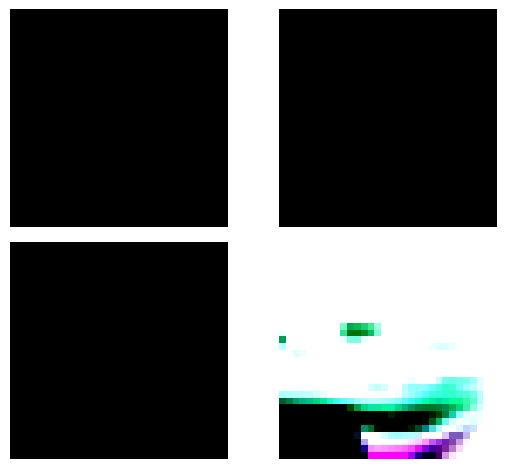

In [5]:
imgs,labels = next(iter(test_loader))

img_list, label_list = [],[]
for i_view in range(2):
    for j_img in range(2):
        img_list.append(imgs[i_view][j_img])
        #label_list.append(classes[labels[i_view][j_img]])
data_utils.show_images(img_list,2,2,label_list)


In [6]:
def sample_submanifolds(backbone,test_dataset,count=2400):
    test_loader = torch.utils.data.DataLoader(test_dataset,batch_size = batch_size,shuffle=False,drop_last=True,
                                            num_workers = 4)
    center_vecs = []
    eigen_vecs = []
    all_labels = []
    traces = []
    i = 0
    for i,data in enumerate(test_loader):
        imgs,labels = data
        if i > count - 1:
            break
        all_labels.append(labels[0].detach().cpu())
        imgs = torch.cat(imgs,dim=0).to(device)
        with torch.no_grad():
            preds = backbone(imgs)
            preds = torch.reshape(preds,(n_views,batch_size,preds.shape[-1]))
            centers = torch.mean(preds,dim=0)
            preds -= centers
            cov = torch.matmul(torch.permute(preds,(1,2,0)), torch.permute(preds,(1,0,2)))/n_views # size B*O*O
            eigen = analysis_utils.power_iteration(cov)
            trace = torch.tensor(analysis_utils.get_cov_traces(cov),requires_grad=False)
            # save as CPU tensor to save GPU memory
            center_vecs.append(centers.detach().cpu())
            eigen_vecs.append(eigen.detach().cpu())
            traces.append(trace)
    center_vecs = torch.cat(center_vecs,dim=0)
    eigen_vecs = torch.cat(eigen_vecs,dim=0)
    traces = torch.cat(traces,dim=0)
    all_labels = torch.cat(all_labels,dim=-1)
    return center_vecs,eigen_vecs,traces,all_labels

In [7]:
#center_vecs,eigen_vecs,traces,all_labels = sample_submanifolds(backbone,test_loader,count=20)

In [8]:
def inner_pairs(indices):
    print(len(indices))
    unique_pairs = [[indices[i], indices[j]] for i in range(len(indices)) for j in range(i+1, len(indices))]
    return np.array(unique_pairs)

In [9]:
def cross_pairs(ind1,ind2):
    pairs = [[ind1[i], ind2[j]] for i in range(len(ind1)) for j in range(len(ind2))]
    return np.array(pairs)

In [10]:
#load the model
# use the randomly initialized model
#load the model
device = torch.device("cuda:0")  # Use GPU 0
ssl_model.backbone.remove_projection_head()
backbone = ssl_model.backbone.to(device)
inner_dist = []
inter_dist = []
inner_sim = []
inter_sim = []
inner_center_sim = []
inter_center_sim = []
for repeat in range(10):
    center_vecs,eigen_vecs,traces,all_labels = sample_submanifolds(backbone,test_dataset,count=100)
    dist_matrix = analysis_utils.get_dist(center_vecs)
    eigen_sim = analysis_utils.get_cosine_sim(eigen_vecs)
    centroid_sim = analysis_utils.get_cosine_sim(center_vecs,rm_mean=True)
    class_indices = [np.where(all_labels==i)[0] for i in range(9)]
    for indices in class_indices:
        pair = inner_pairs(indices)
        inner_dist.append(dist_matrix[pair[:,0],pair[:,1]])
        inner_sim.append(eigen_sim[pair[:,0],pair[:,1]])
        inner_center_sim.append(centroid_sim[pair[:,0],pair[:,1]])
    for i in range(len(class_indices)):
        for j in range(len(class_indices)):
            pair = cross_pairs(class_indices[i],class_indices[j])
            inter_dist.append(dist_matrix[pair[:,0],pair[:,1]])
            inter_sim.append(eigen_sim[pair[:,0],pair[:,1]])
            inter_center_sim.append(centroid_sim[pair[:,0],pair[:,1]])

80
66
81
78
71
75
95
78
84
80
66
81
78
71
75
95
78
84
80
66
81
78
71
75
95
78
84
80
66
81
78
71
75
95
78
84
80
66
81
78
71
75
95
78
84
80
66
81
78
71
75
95
78
84
80
66
81
78
71
75
95
78
84
80
66
81
78
71
75
95
78
84
80
66
81
78
71
75
95
78
84
80
66
81
78
71
75
95
78
84


In [11]:
inner_dist = np.concatenate(inner_dist,axis=0)
inter_dist = np.concatenate(inter_dist,axis=0)
# remove self distance
inner_dist = inner_dist[np.where(inner_dist>1e-6)]
inter_dist = inter_dist[np.where(inter_dist>1e-6)]

inner_sim = np.concatenate(inner_sim,axis=0)
inter_sim = np.concatenate(inter_sim,axis=0)
# remove self similarity
inner_sim = inner_sim[np.where(inner_sim < 1-1e-6)]**2
inter_sim = inter_sim[np.where(inter_sim < 1-1e-6)]**2
# remove self similarity
inner_center_sim = np.concatenate(inner_center_sim,axis=0)
inter_center_sim = np.concatenate(inter_center_sim,axis=0)
inner_center_sim = inner_center_sim[np.where(inner_center_sim < 1-1e-6)]
inter_center_sim = inter_center_sim[np.where(inter_center_sim < 1-1e-6)]

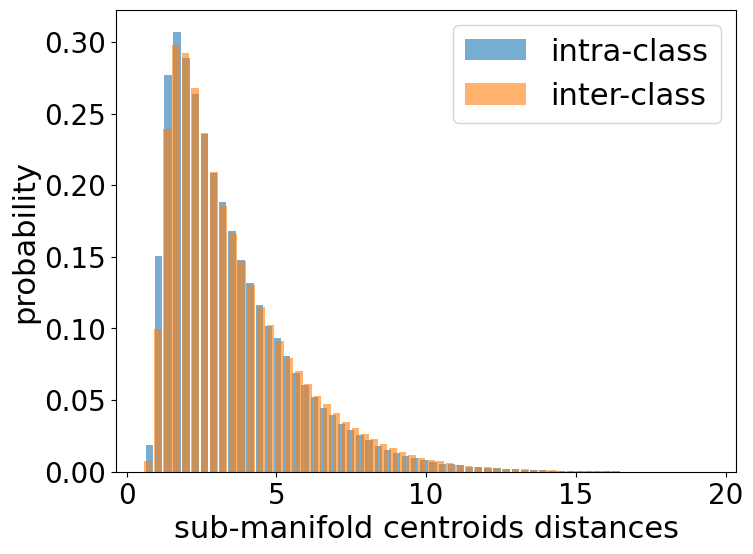

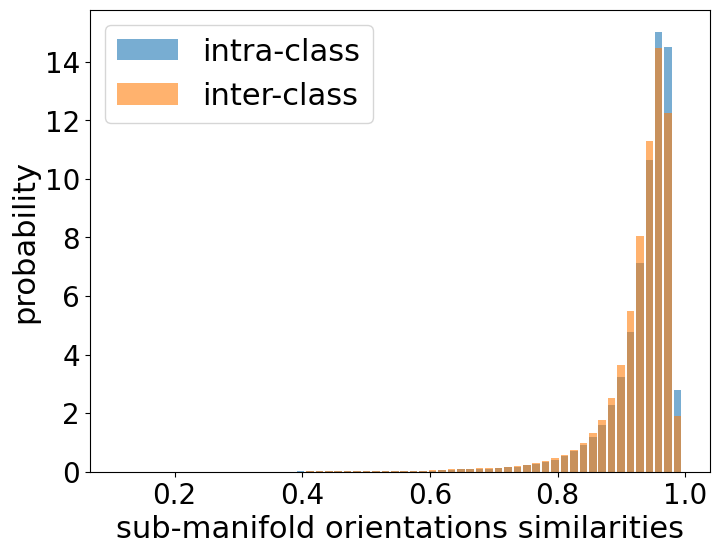

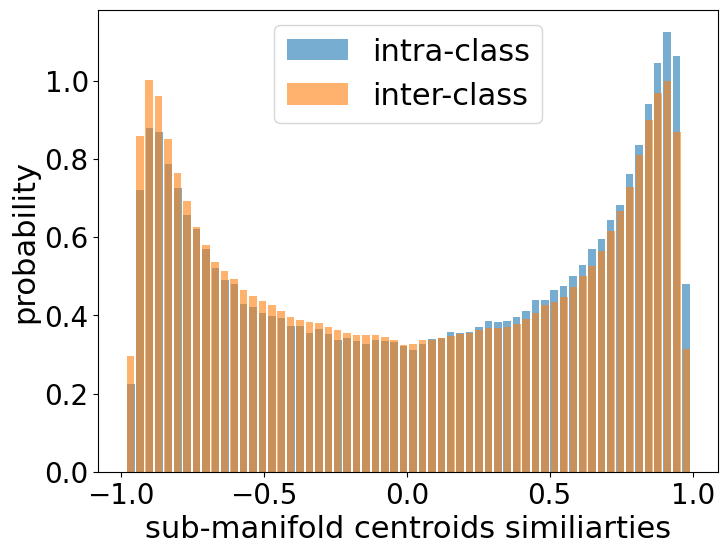

In [12]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_axes(111)
ax.hist(inner_dist, bins=60, density=True, rwidth=0.8,alpha=0.6,label="intra-class")
ax.hist(inter_dist, bins=60, density=True, rwidth=0.8,alpha=0.6,label="inter-class")
ax.legend(fontsize=22)
ax.set_xlabel("sub-manifold centroids distances",fontsize=22)
ax.set_ylabel("probability",fontsize=22)
ax.tick_params(axis='both', labelsize=20)
plt.savefig("./centroid_distance_untrained.jpg",dpi=600,bbox_inches='tight')

fig = plt.figure(figsize=(8, 6))
ax = fig.add_axes(111)
ax.hist(inner_sim, bins=60, rwidth=0.8,alpha=0.6,density = True,label="intra-class")
ax.hist(inter_sim, bins=60, rwidth=0.8,alpha=0.6,density = True,label="inter-class")
ax.legend(fontsize=22)
ax.set_xlabel("sub-manifold orientations similarities",fontsize=22)
ax.set_ylabel("probability",fontsize=22)
ax.tick_params(axis='both', labelsize=20)
plt.savefig("./orientaion_similarity_untrained.jpg",dpi=600,bbox_inches='tight')

fig = plt.figure(figsize=(8, 6))
ax = fig.add_axes(111)
ax.hist(inner_center_sim, bins=60, rwidth=0.8,alpha=0.6,density = True,label="intra-class")
ax.hist(inter_center_sim, bins=60, rwidth=0.8,alpha=0.6,density = True,label="inter-class")
ax.set_xlabel("sub-manifold centroids similiarties",fontsize=22)
ax.set_ylabel("probability",fontsize=22)
ax.legend(fontsize=22)
ax.tick_params(axis='both', labelsize=20)
plt.savefig("./centroid_similarity_untrained.jpg",dpi=600,bbox_inches='tight')

In [13]:
#load the model
device = torch.device("cuda:0")  # Use GPU 0
trained_filename = os.path.join(model_dir,"ssl",'ssl-epoch=999.ckpt')
if os.path.isfile(trained_filename):
    print(f'Found pretrained model at {trained_filename}, loading...')
    ssl_model = lightning_models.CLAP.load_from_checkpoint(trained_filename)
ssl_model.backbone.remove_projection_head()
backbone = ssl_model.backbone.to(device)
inner_dist = []
inter_dist = []
inner_sim = []
inter_sim = []
inner_center_sim = []
inter_center_sim = []


Found pretrained model at ../best_cifar10/ssl/ssl-epoch=999.ckpt, loading...


/home/guanming/miniconda3/envs/mydl/lib/python3.8/site-packages/lightning_fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
/home/guanming/miniconda3/envs/mydl/l

max_mem_size is dummy for LogRepulsiveEllipsoidPackingLossUnitNorm
lw2 is dummy for LogRepulsiveEllipsoidPackingLossUnitNorm


In [14]:
for repeat in range(10):
    center_vecs,eigen_vecs,traces,all_labels = sample_submanifolds(backbone,test_dataset,count=100)
    dist_matrix = analysis_utils.get_dist(center_vecs)
    eigen_sim = analysis_utils.get_cosine_sim(eigen_vecs)
    centroid_sim = analysis_utils.get_cosine_sim(center_vecs,rm_mean=True)
    class_indices = [np.where(all_labels==i)[0] for i in range(9)]
    for indices in class_indices:
        pair = inner_pairs(indices)
        inner_dist.append(dist_matrix[pair[:,0],pair[:,1]])
        inner_sim.append(eigen_sim[pair[:,0],pair[:,1]])
        inner_center_sim.append(centroid_sim[pair[:,0],pair[:,1]])
    for i in range(len(class_indices)):
        for j in range(len(class_indices)):
            pair = cross_pairs(class_indices[i],class_indices[j])
            inter_dist.append(dist_matrix[pair[:,0],pair[:,1]])
            inter_sim.append(eigen_sim[pair[:,0],pair[:,1]])
            inter_center_sim.append(centroid_sim[pair[:,0],pair[:,1]])

80
66
81
78
71
75
95
78
84
80
66
81
78
71
75
95
78
84
80
66
81
78
71
75
95
78
84
80
66
81
78
71
75
95
78
84
80
66
81
78
71
75
95
78
84
80
66
81
78
71
75
95
78
84
80
66
81
78
71
75
95
78
84
80
66
81
78
71
75
95
78
84
80
66
81
78
71
75
95
78
84
80
66
81
78
71
75
95
78
84


In [15]:
inner_dist = np.concatenate(inner_dist,axis=0)
inter_dist = np.concatenate(inter_dist,axis=0)
# remove self distance
inner_dist = inner_dist[np.where(inner_dist>1e-6)]
inter_dist = inter_dist[np.where(inter_dist>1e-6)]

inner_sim = np.concatenate(inner_sim,axis=0)
inter_sim = np.concatenate(inter_sim,axis=0)
# remove self similarity
inner_sim = inner_sim[np.where(inner_sim < 1-1e-6)]**2
inter_sim = inter_sim[np.where(inter_sim < 1-1e-6)]**2
# remove self similarity
inner_center_sim = np.concatenate(inner_center_sim,axis=0)
inter_center_sim = np.concatenate(inter_center_sim,axis=0)
inner_center_sim = inner_center_sim[np.where(inner_center_sim < 1-1e-6)]
inter_center_sim = inter_center_sim[np.where(inter_center_sim < 1-1e-6)]

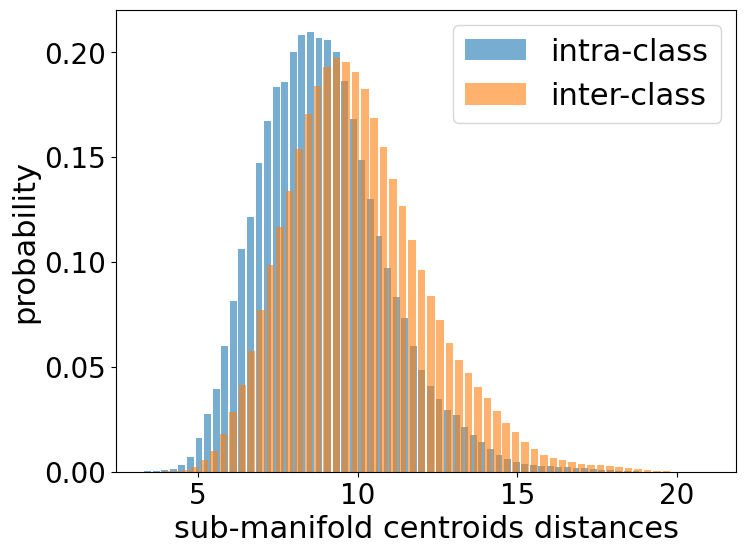

In [16]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_axes(111)
ax.hist(inner_dist, bins=60, density=True, rwidth=0.8,alpha=0.6,label="intra-class")
ax.hist(inter_dist, bins=60, density=True, rwidth=0.8,alpha=0.6,label="inter-class")
ax.legend(fontsize=22)
ax.set_xlabel("sub-manifold centroids distances",fontsize=22)
ax.set_ylabel("probability",fontsize=22)
ax.tick_params(axis='both', labelsize=20)
plt.savefig("./centroid_distance_trained.jpg",dpi=600,bbox_inches='tight')

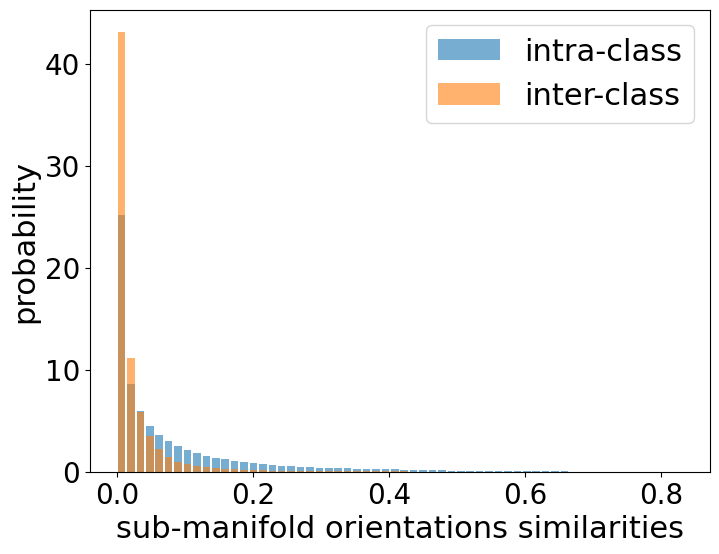

In [17]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_axes(111)
ax.hist(inner_sim, bins=60, rwidth=0.8,alpha=0.6,density = True,label="intra-class")
ax.hist(inter_sim, bins=60, rwidth=0.8,alpha=0.6,density = True,label="inter-class")
ax.legend(fontsize=22)
ax.set_xlabel("sub-manifold orientations similarities",fontsize=22)
ax.set_ylabel("probability",fontsize=22)
ax.tick_params(axis='both', labelsize=20)
plt.savefig("./orientaion_similarity_trained.jpg",dpi=600,bbox_inches='tight')

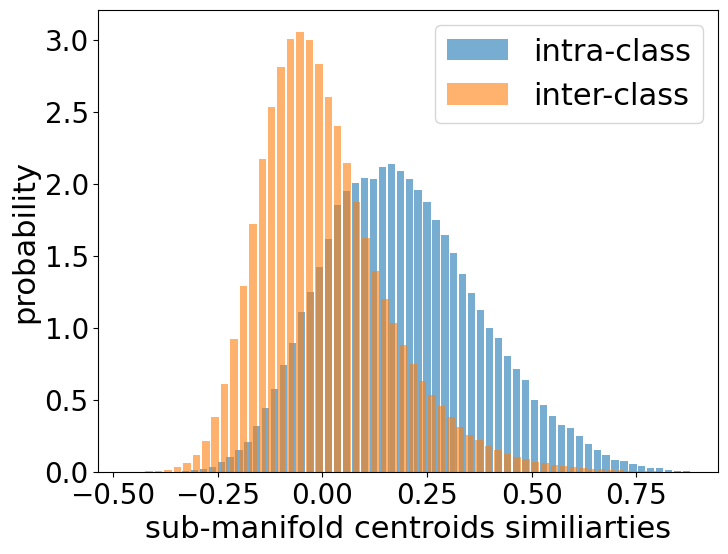

In [18]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_axes(111)
ax.hist(inner_center_sim, bins=60, rwidth=0.8,alpha=0.6,density = True,label="intra-class")
ax.hist(inter_center_sim, bins=60, rwidth=0.8,alpha=0.6,density = True,label="inter-class")
ax.set_xlabel("sub-manifold centroids similiarties",fontsize=22)
ax.set_ylabel("probability",fontsize=22)
ax.legend(fontsize=22)
ax.tick_params(axis='both', labelsize=20)
plt.savefig("./centroid_similarity_trained.jpg",dpi=600,bbox_inches='tight')

In [19]:
np.where(all_labels==2)[0]

array([ 25,  35,  65,  67,  70,  75,  84,  86, 113, 118, 123, 129, 135,
       138, 147, 149, 156, 160, 182, 183, 195, 219, 248, 249, 266, 270,
       291, 303, 307, 322, 340, 342, 353, 354, 357, 374, 384, 387, 388,
       391, 393, 396, 409, 424, 430, 436, 448, 449, 450, 497, 498, 537,
       548, 559, 563, 564, 569, 592, 603, 618, 623, 630, 655, 674, 691,
       692, 697, 701, 706, 725, 731, 740, 748, 751, 754, 755, 758, 765,
       775, 776, 799])

In [20]:
test_dataset = datasets.CIFAR10(root="../datasets/cifar10", train=False,download=False)
aug_ops = ["ToTensor","Normalize"]
config.DATA["mean4norm"] = [0.491,0.482,0.446]
config.DATA["std4norm"] = [0.247,0.243,0.261]  
transform = data_utils.get_transform(aug_ops,aug_params=config.DATA,aug_pkg="torchvision")
test_dataset = data_utils.WrappedDataset(test_dataset,[transform],n_views = 2,aug_pkg="torchvision")
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size = batch_size,shuffle=True,drop_last=True,
                                              num_workers = 4,pin_memory=True)

In [21]:
# calculate the participation ratio

In [22]:
data_dir = "../datasets/cifar10"

aug_ops = [["ToTensor","Normalize"]]
aug_params = [dict()] 
mean = [0.491,0.482,0.446]
std = [0.247,0.243,0.261]
test_dataset = datasets.CIFAR10(root=data_dir, train=False,download=True)
test_transforms = [v2.Compose([v2.ToImage(),v2.ToDtype(torch.float32,scale=True),
                                     v2.Normalize(mean=mean,std=std)])]
test_dataset = data_utils.WrappedDataset(test_dataset,test_transforms,n_views = 1,aug_pkg="torchvision")
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size = 8,shuffle=False,drop_last=True,num_workers = 4)

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<Figure size 640x480 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: >, <Axes: >]], dtype=object))

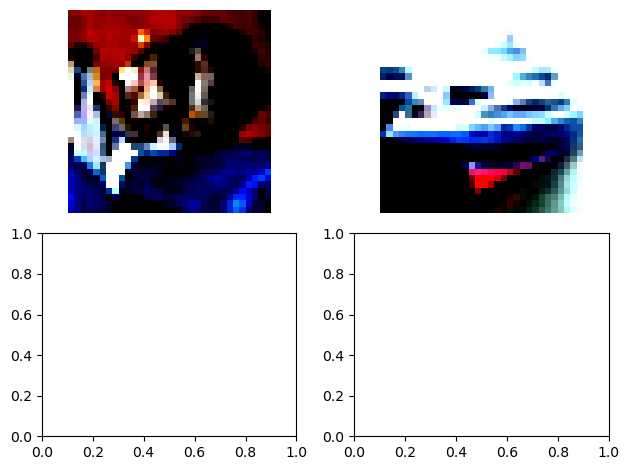

In [23]:
imgs,labels = next(iter(test_loader))
img_list, label_list = [],[]
for i_view in range(1):
    for j_img in range(2):
        img_list.append(imgs[i_view][j_img])
        #label_list.append(classes[labels[i_view][j_img]])
data_utils.show_images(img_list,2,2,label_list)

In [24]:
def get_embedding_covariance(backbone,test_dataset,batch_size=8,count=2400):
    test_loader = torch.utils.data.DataLoader(test_dataset,batch_size = 8,shuffle=True,drop_last=True,num_workers = 4)
    embeddings = []
    i = 0
    for i,data in enumerate(test_loader):
        imgs,labels = data
        if i > count - 1:
            break
        imgs = torch.cat(imgs,dim=0).to(device)
        with torch.no_grad():
            preds = backbone(imgs)
            preds = torch.reshape(preds,(1,batch_size,preds.shape[-1])) # n_veiws = 1
            embeddings.append(torch.squeeze(preds).detach().cpu().numpy())
    features = np.concatenate(embeddings) # shape = (count*ouput_dim)
    center = np.mean(features,axis=0,keepdims=True)
    features = features - center
    #cov = np.einsum("ij,ik->jk",reps,reps) 
    cov = np.matmul(np.transpose(features),features)
    print(cov.shape)
    cov /= (features.shape[0]-1.0)
    return cov

In [25]:
model = torchvision.models.resnet18(pretrained=False)
model.maxpool = torch.nn.Identity()
model.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=2, bias=False) 
model.fc = torch.nn.Identity()
device = torch.device("cuda:0")  # Use GPU 0
backbone = model.to(device)
pr = []
for repreat in range(10):
    cov = get_embedding_covariance(backbone,test_dataset,count=200)
    vals,vecs = np.linalg.eig(cov)
    _pr = (np.sum(vals)**2) /np.sum(vals*vals)
    pr.append(_pr)
print(pr)
print("partition ratio")
print(np.mean(pr))
print("std")
print(np.std(pr))

/home/guanming/miniconda3/envs/mydl/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/guanming/miniconda3/envs/mydl/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
[2.716313212042916, 2.9100822887530002, 2.980081279559718, 2.8919012588081747, 2.934230888295965, 2.8132439555539333, 2.9330554603197796, 2.8193516288917317, 2.911979880711935, 2.819527832347219]
partition ratio
2.8729767685284378
std
0.07478837787991162


In [26]:
model = torchvision.models.resnet18(pretrained=False)
model.maxpool = torch.nn.Identity()
model.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=2, bias=False) 
model.fc = torch.nn.Identity()
model.load_state_dict(torch.load(os.path.join(model_dir,"ssl","last_epoch_backbone_resnet18.ckpt"),weights_only=True))
device = torch.device("cuda:0")  # Use GPU 0
backbone = model.to(device)
pr = []
for repreat in range(10):
    cov = get_embedding_covariance(model,test_dataset,count=800)
    vals,vecs = np.linalg.eig(cov)
    _pr = (np.sum(vals)**2) /np.sum(vals*vals)
    pr.append(_pr)
print("partition ratio")
print(np.mean(pr))
print("std")
print(np.std(pr))
print(pr)

(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
partition ratio
62.107533679326615
std
0.5695914475021079
[61.85791625663014, 61.99736168965848, 61.94615401780896, 62.14271445528861, 62.714250670577684, 62.04953217551608, 61.79509236619768, 60.87621663105249, 62.67389593049651, 63.02220260003949]


In [29]:
model = torchvision.models.resnet18(pretrained=False)
#model.maxpool = torch.nn.Identity()
#model.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=2, bias=False) 
model.fc = torch.nn.Identity()
model.maxpool = torch.nn.Identity()
device = torch.device("cuda:0")  # Use GPU 0
backbone = model.to(device)
pr = []
for repreat in range(10):
    cov = get_embedding_covariance(backbone,test_dataset,count=200)
    vals,vecs = np.linalg.eig(cov)
    _pr = (np.sum(vals)**2) /np.sum(vals*vals)
    pr.append(_pr)
print(pr)
print("partition ratio")
print(np.mean(pr))
print("std")
print(np.std(pr))

(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
[31.691816310752902, 27.972665474110986, 28.362261291415706, 31.454223008501604, 30.65768854135371, 28.725608430300696, 28.194818404644025, 31.36131792617377, 29.43242390365168, 29.098689347698393]
partition ratio
29.695151263860346
std
1.3835805550008113
